## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv'
df_insure = pd.read_csv(url)
df_insure.head()
sample = df_insure.sample(n=100,random_state=42)
smoker_charges = sample.loc[ sample['smoker']=='yes',"charges"]
nonsmoker_charges = sample.loc[ sample['smoker']=='no',"charges"]
## Getting means for gender height
print(f"For smokers (n={len(smoker_charges)}): Mean={np.mean(smoker_charges):.2f}")
print(f"For non smokers (n={len(nonsmoker_charges)}): Mean={np.mean(nonsmoker_charges):.2f}")

For smokers (n=22): Mean=32997.31
For non smokers (n=78): Mean=8394.54


In [4]:
df_insure.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Hypothesis

## Hypothesis: 1

Null Hypothesis: There is no significant difference in insurance charges between smokers and non-smokers.

Alternative Hypothesis: There is a significant difference in insurance charges between smokers and non-smokers.

Using an alpha=.05

### Assumptions:Independent T-Test 
- No significant outliers
- Normality
- Equal Variance

### Testing for Outliers

In [3]:
zscores_f = stats.zscore(smoker_charges)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)

0

In [5]:
zscores_f = stats.zscore(nonsmoker_charges)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)

2

In [10]:
# remove outliers from nonsmoker_charges group
nonsmoker_charges = nonsmoker_charges[(np.abs(stats.zscore(nonsmoker_charges)) < 3)]

There are no more outliers in our data.

### Test Each Group for Normality

In [33]:
# normal test smokers
result_s = stats.normaltest(smoker_charges)
result_s

NormaltestResult(statistic=8.481188655372003, pvalue=0.014399031556451041)

In [36]:
# normal test non-smokers
result_ns = stats.normaltest(nonsmoker_charges)
result_ns

NormaltestResult(statistic=4.011538559343466, pvalue=0.1345567441026122)

#### Both Results are less than the aplha this would mean we will reject the null hypothesis

### Testing for Equal Variance with Levene's test

In [15]:
result = stats.levene(smoker_charges, nonsmoker_charges)
result

LeveneResult(statistic=52.55139101636291, pvalue=1.2139255409014474e-10)

#### low pvalue leven results would indicate we don't have equal variances

### Perform and evaluate the t-test

We will perform the independent t-test. 

In [16]:
result2 = stats.ttest_ind(smoker_charges, nonsmoker_charges, equal_var = False)
result2

Ttest_indResult(statistic=11.441281148432447, pvalue=5.6151366040908574e-11)

#### based on the results of the t-test, there is strong evidence to suggest that there is a significant difference in insurance charges between smokers and non-smokers.

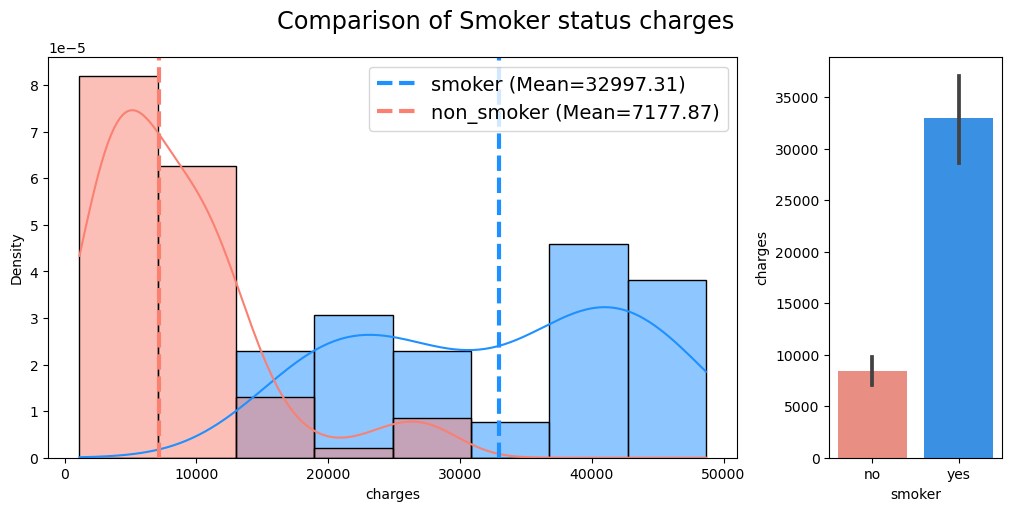

In [17]:
smoker_palette={'yes':'dodgerblue', "no":'salmon'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=sample, x='charges',fill=True,hue='smoker',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=smoker_palette)

ax.axvline(np.mean(smoker_charges), ls='--',lw=3, 
           label=f"smoker (Mean={np.mean(smoker_charges):.2f})",color=smoker_palette['yes'])

ax.axvline(np.mean(nonsmoker_charges), ls='--', lw=3, 
           label=f"non_smoker (Mean={np.mean(nonsmoker_charges):.2f})",color=smoker_palette['no'])

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=sample, x='smoker',y='charges',ax = ax_bar,palette=smoker_palette)
fig.suptitle('Comparison of Smoker status charges',fontsize='xx-large');

## Hypothesis: 2

Null Hypothesis: The proportion of men who smoke is equal to the proportion of women who smoke.

Alternative Hypothesis: The proportion of men who smoke is greater than the proportion of women who smoke, visa versa

Using an alpha=.05

In [18]:
df_insure.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Test Assumptions - Chi-Square test
- categorical variables
- Independant Outcome

### Contingency Table with pd.crosstab

In [19]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df_insure['sex'], df_insure['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [20]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [21]:
# What was our p-value?
print(p)
p<.05

0.0065481435035807025


True

Since p<.05, this confirms that the p-value is less than 0.05 we reject the null hypothesis.

Result indicates that there is a significant difference in smoking rates between men and women based on the data

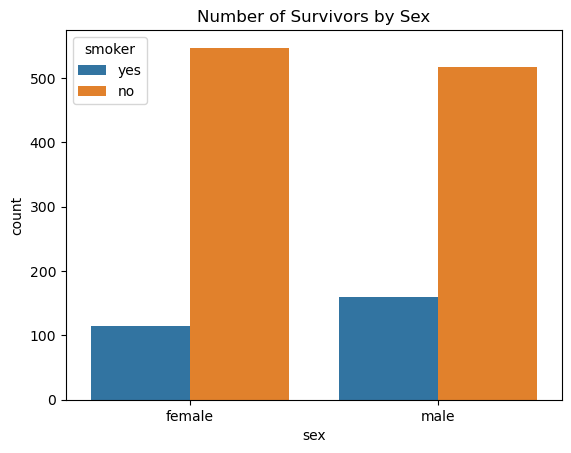

In [22]:
# First, let's visualize survivorship by sex.
ax = sns.countplot(data=df_insure, x='sex',hue='smoker',)
ax.set_title("Number of Survivors by Sex");

## Hypothesis: 3

Null Hypothesis: The average charges are the same across all regions..

Alternative Hypothesis: At least one region has a different average charge.

Using an alpha=.05

### Separating Our Groups

In [23]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df_insure['region'].unique():
    ## Get series for group and rename
    data = df_insure.loc[df_insure['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

### Testing Assumptions - Anova

#### Assumption of Normality

In [24]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [25]:
## checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


The SIG = True suggest that for each region we would reject he null hypothesis

#### Assumption of Equal Variance

In [26]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250782834)

based on the above low pvalue results indicate we have NOT met the assumption of equal variance.

### One-Way ANOVA Test

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df_insure['charges']
labels = df_insure['region']

In [28]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


Based on the results above there are significant differences in charges between:
- northeast and southeast
- northwest and southeast

The charges was significantly higher for the southeast region

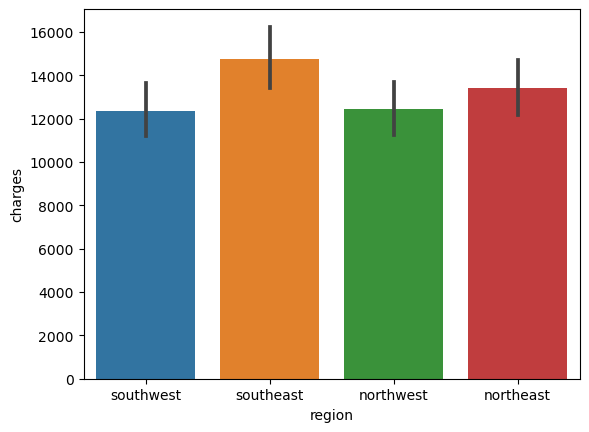

In [29]:
sns.barplot(data=df_insure, x='region',y='charges');